In [2]:
#%% General Imports
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import os
from matplotlib import pyplot as plt

#sklearn imports
from sklearn.model_selection import LeaveOneOut, train_test_split
import sklearn.linear_model as linear_model
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler


# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

# botorch dependencies
import botorch

# data related
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.utils.sampling import draw_sobol_samples




In [3]:
REPO = 'viscosity_liquid_transfer_Pablo'
parent_path = os.getcwd().split(REPO)[0]

## Sartorious

Initialization data, linear model


In [38]:
results_df = pd.DataFrame(columns=['name','volume','coefs_error','intercept_error', 'r2_error' ,'coefs_time','intercept_time', 'r2_time'])
initialization_dfs = {}

for file in os.listdir(parent_path+'\\'+REPO+r'\Sartorious_experiments\Initialisation_Data'):
    initialization_dfs[file.split('_')[1][:-4]] = pd.read_csv(parent_path+'\\'+REPO+'\\Sartorious_experiments\\Initialisation_Data\\'+file)
    initialization_dfs[file.split('_')[1][:-4]]['time_asp_1000'] = 1000/initialization_dfs[file.split('_')[-1][:-4]]['aspiration_rate'] + 1000/initialization_dfs[file.split('_')[-1][:-4]]['dispense_rate'] + initialization_dfs[file.split('_')[-1][:-4]]['delay_aspirate'] + initialization_dfs[file.split('_')[-1][:-4]]['delay_dispense']

for key in initialization_dfs.keys():
    linear = linear_model.LinearRegression()
    scaler = StandardScaler()

    df_duplicates =initialization_dfs[key].where(initialization_dfs[key].duplicated(['aspiration_rate','dispense_rate'],keep=False)==True).dropna(how='all')
    df_incomplete = initialization_dfs[key].where(initialization_dfs[key].duplicated(['aspiration_rate','dispense_rate'],keep=False)==False).dropna(how='all')
    df_mean = pd.DataFrame(columns= initialization_dfs[key].columns)
    for index,values in df_duplicates.drop_duplicates(['aspiration_rate','dispense_rate']).iterrows():
        if len(df_duplicates.loc[index:index+2]) == len([300,500,1000]):
            mean_error =df_duplicates.loc[index:index+2,'%error'].abs().mean()
            df_duplicates.loc[index,'%error'] = -mean_error
            df_duplicates.loc[index, 'volume'] ='mean'+str([300,500,1000])
            df_mean = pd.concat([df_mean,initialization_dfs[key].loc[index:index+2],df_duplicates.loc[[index]]])
        else:
            df_incomplete = pd.concat([df_incomplete,df_duplicates.loc[index:index+2]]).drop_duplicates()
    df_mean = pd.concat([df_mean,df_incomplete])
    df_mean = df_mean.reset_index(drop=True)   

    for volume in [ 300,500,1000,'mean[300, 500, 1000]']:
        results_df_row = {'name': f'standard_{key}','volume':volume}
        df_1_vol = df_mean.where(df_mean.volume==volume).dropna(how='all')
        x = df_1_vol.loc[:,['aspiration_rate','dispense_rate']]
        x = scaler.fit_transform(x)
        y = df_1_vol.loc[:,['%error','time_asp_1000']]
        linear.fit(x,y.iloc[:,0])
        results_df_row.update([('coefs_error',str(linear.coef_)),('intercept_error',linear.intercept_),( 'r2_error',linear.score(x,y.iloc[:,0]))])
        linear.fit(x,y.iloc[:,1])
        results_df_row.update([('coefs_time',str(linear.coef_)),('intercept_time',linear.intercept_),( 'r2_time',linear.score(x,y.iloc[:,1]))])
        results_df = pd.concat([results_df,pd.DataFrame(results_df_row,index=[0])], ignore_index=True)
results_df.to_csv('initialization_Sartorious_linear_fit_summary.csv', index=False)
results_df

,name,volume,coefs_error,intercept_error,r2_error,coefs_time,intercept_time,r2_time
0,standard_1275,300,[-7.18591988 -2.56959397],-16.467229,0.961859,[-158.27948606 -158.27948606],332.639049,0.960242
1,standard_1275,500,[-4.43745294 -1.96156348],-12.611836,0.757590,[-158.27948606 -158.27948606],332.639049,0.960242
2,standard_1275,1000,[-4.39007718 -5.15946483],-14.182037,0.654877,[-158.27948606 -158.27948606],332.639049,0.960242
3,standard_1275,"mean[300, 500, 1000]",[-5.33781667 -3.23020743],-14.420367,0.944994,[-158.27948606 -158.27948606],332.639049,0.960242
4,standard_204,300,[ 2.01586141 -6.06783343],-9.393205,0.912160,[-35.99972197 -35.99972197],91.107881,0.960242
5,standard_204,500,[ 0.83523839 -4.14568695],-6.291306,0.889942,[-35.99972197 -35.99972197],91.107881,0.960242
6,standard_204,1000,[ 0.42564672 -8.17621373],-11.732504,0.954823,[-35.99972197 -35.99972197],91.107881,0.960242
7,standard_204,"mean[300, 500, 1000]",[ 1.09224884 -6.12991137],-9.139005,0.939762,[-35.99972197 -35.99972197],91.107881,0.960242
8,standard_398,300,[-0.01877947 -5.47265907],-11.992893,0.990019,[-25.24145172 -25.24145175],69.857778,0.960242
9,standard_398,500,[-0.15662097 -6.63617096],-9.762415,0.987379,[-25.24145172 -25.24145175],69.857778,0.960242


Optimization results

In [103]:
results_df = pd.DataFrame(columns=['name','volume','coefs_error','intercept_error', 'r2_error' ,'coefs_time','intercept_time', 'r2_time'])
initialization_dfs = {}

for file in os.listdir(parent_path+'\\'+REPO+r'\Sartorious_experiments\Cleaned_Data'):
    if 'exp3' in file:
        initialization_dfs[file.split('_exp3')[0]] = pd.read_csv(parent_path+'\\'+REPO+'\\Sartorious_experiments\\Cleaned_Data\\'+file)
        initialization_dfs[file.split('_exp3')[0]]['time_asp_1000'] = 1000/initialization_dfs[file.split('_exp3')[0]]['aspiration_rate'] + 1000/initialization_dfs[file.split('_exp3')[0]]['dispense_rate'] + initialization_dfs[file.split('_exp3')[0]]['delay_aspirate'] + initialization_dfs[file.split('_exp3')[0]]['delay_dispense']

for key in initialization_dfs.keys():
    linear = linear_model.LinearRegression()
    scaler = StandardScaler()
    
    df_duplicates =initialization_dfs[key].where(initialization_dfs[key].duplicated(['aspiration_rate','dispense_rate'],keep=False)==True).dropna(how='all')
    df_incomplete = initialization_dfs[key].where(initialization_dfs[key].duplicated(['aspiration_rate','dispense_rate'],keep=False)==False).dropna(how='all')
    df_mean = pd.DataFrame(columns= initialization_dfs[key].columns)
    for index,values in df_duplicates.drop_duplicates(['aspiration_rate','dispense_rate']).iterrows():
        if len(df_duplicates.loc[index:index+2]) == len([300,500,1000]):
            mean_error =df_duplicates.loc[index:index+2,'%error'].mean()
            df_duplicates.loc[index,'%error'] = mean_error
            df_duplicates.loc[index, 'volume'] ='mean'+str([300,500,1000])
            df_mean = pd.concat([df_mean,initialization_dfs[key].loc[index:index+2],df_duplicates.loc[[index]]])
        else:
            df_incomplete = pd.concat([df_incomplete,df_duplicates.loc[index:index+2]]).drop_duplicates()
    df_mean = pd.concat([df_mean,df_incomplete])
    df_mean = df_mean.reset_index(drop=True)   

    for volume in [ '300.0','500.0','1000.0']:
        index = df_mean.where(df_mean.volume==volume).dropna(how='all').index
        df_mean.loc[index,'volume'] = volume[:-2]

    for volume in [ '300','500','1000','mean[300, 500, 1000]']:
        results_df_row = {'name': f'standard_{key}','volume':volume}
        df_1_vol = df_mean.where(df_mean.volume==volume).dropna(how='all')
        x = df_1_vol.loc[:,['aspiration_rate','dispense_rate']]
        x = scaler.fit_transform(x)
        y = df_1_vol.loc[:,['%error','time_asp_1000']]
        linear.fit(x,y.iloc[:,0])
        results_df_row.update([('coefs_error',str(linear.coef_)),('intercept_error',linear.intercept_),( 'r2_error',linear.score(x,y.iloc[:,0]))])
        linear.fit(x,y.iloc[:,1])
        results_df_row.update([('coefs_time',str(linear.coef_)),('intercept_time',linear.intercept_),( 'r2_time',linear.score(x,y.iloc[:,1]))])
        results_df = pd.concat([results_df,pd.DataFrame(results_df_row,index=[0])], ignore_index=True)
results_df.to_csv('optimization_Sartorious_linear_fit_summary.csv', index=False)
results_df

,name,volume,coefs_error,intercept_error,r2_error,coefs_time,intercept_time,r2_time
0,standard_Viscosity_std_204,300,[ 1.79831462 -5.15902125],-6.788986,0.889069,[-27.91536457 -19.41507445],80.238442,0.662869
1,standard_Viscosity_std_204,500,[ 0.60393279 -3.36971108],-4.648152,0.876737,[-27.91536457 -19.41507445],80.238442,0.662869
2,standard_Viscosity_std_204,1000,[ 0.35799523 -7.260083 ],-7.358462,0.961992,[-27.91536457 -19.41507445],80.238442,0.662869
3,standard_Viscosity_std_204,"mean[300, 500, 1000]",[ 0.92008088 -5.26293844],-6.265200,0.955211,[-27.91536457 -19.41507445],80.238442,0.662869
4,standard_Viscosity_std_505,300,[-1.42984809 -1.56402767],-4.838670,0.615360,[-48.27510712 -38.82794364],144.247356,0.668883
5,standard_Viscosity_std_505,500,[-2.22314377 -2.37951218],-4.228840,0.619170,[-48.27510712 -38.82794364],144.247356,0.668883
6,standard_Viscosity_std_505,1000,[ 0.27782266 -8.11379076],-8.173269,0.974654,[-48.27510712 -38.82794364],144.247356,0.668883
7,standard_Viscosity_std_505,"mean[300, 500, 1000]",[-1.1250564 -4.0191102],-5.746927,0.928741,[-48.27510712 -38.82794364],144.247356,0.668883


## Opentrons 

Initialization data, linear model


In [36]:
results_df = pd.DataFrame(columns=['name','volume','coefs_error','intercept_error', 'r2_error' ,'coefs_time','intercept_time', 'r2_time'])
initialization_dfs = {}

for file in os.listdir(parent_path+'\\'+REPO+r'\Opentrons_experiments\BOTorch_optimization\CCF_initialization'):
    if 'wrong' not in file:
        initialization_dfs[file.split('_')[-1][:-4]] = pd.read_csv(parent_path+'\\'+REPO+'\\Opentrons_experiments\\BOTorch_optimization\\CCF_initialization\\'+file)
        initialization_dfs[file.split('_')[-1][:-4]]['time_asp_1000'] = 1000/initialization_dfs[file.split('_')[-1][:-4]]['aspiration_rate'] + 1000/initialization_dfs[file.split('_')[-1][:-4]]['dispense_rate'] + initialization_dfs[file.split('_')[-1][:-4]]['delay_aspirate'] + initialization_dfs[file.split('_')[-1][:-4]]['delay_dispense']
for key in initialization_dfs.keys():
    linear = linear_model.LinearRegression()
    scaler = StandardScaler()

    df_duplicates =initialization_dfs[key].where(initialization_dfs[key].duplicated(['aspiration_rate','dispense_rate'],keep=False)==True).dropna(how='all')
    df_incomplete = initialization_dfs[key].where(initialization_dfs[key].duplicated(['aspiration_rate','dispense_rate'],keep=False)==False).dropna(how='all')
    df_mean = pd.DataFrame(columns= initialization_dfs[key].columns)
    for index,values in df_duplicates.drop_duplicates(['aspiration_rate','dispense_rate']).iterrows():
        if len(df_duplicates.loc[index:index+2]) == len([300,500,1000]):
            mean_error =df_duplicates.loc[index:index+2,'%error'].abs().mean()
            df_duplicates.loc[index,'%error'] = -mean_error
            df_duplicates.loc[index, 'volume'] ='mean'+str([300,500,1000])
            df_mean = pd.concat([df_mean,initialization_dfs[key].loc[index:index+2],df_duplicates.loc[[index]]])
        else:
            df_incomplete = pd.concat([df_incomplete,df_duplicates.loc[index:index+2]]).drop_duplicates()
    df_mean = pd.concat([df_mean,df_incomplete])
    df_mean = df_mean.reset_index(drop=True)   

    for volume in [ 300,500,1000,'mean[300, 500, 1000]']:
        results_df_row = {'name': f'standard_{key}','volume':volume}
        df_1_vol = df_mean.where(df_mean.volume==volume).dropna(how='all')
        x = df_1_vol.loc[:,['aspiration_rate','dispense_rate']]
        x = scaler.fit_transform(x)
        y = df_1_vol.loc[:,['%error','time_asp_1000']]
        linear.fit(x,y.iloc[:,0])
        results_df_row.update([('coefs_error',str(linear.coef_)),('intercept_error',linear.intercept_),( 'r2_error',linear.score(x,y.iloc[:,0]))])
        linear.fit(x,y.iloc[:,1])
        results_df_row.update([('coefs_time',str(linear.coef_)),('intercept_time',linear.intercept_),( 'r2_time',linear.score(x,y.iloc[:,1]))])
        results_df = pd.concat([results_df,pd.DataFrame(results_df_row,index=[0])], ignore_index=True)

        

results_df.to_csv('initialization_Opentrons_linear_fit_summary.csv', index=False)
results_df

,name,volume,coefs_error,intercept_error,r2_error,coefs_time,intercept_time,r2_time
0,standard_1275,300,[-10.00489479 -16.74596882],-11.691087,0.879682,[-207.45526143 -207.45526143],419.772764,0.960242
1,standard_1275,500,[ -7.30459566 -10.58888916],-14.148352,0.892217,[-207.45526143 -207.45526143],419.772764,0.960242
2,standard_1275,1000,[-4.92915041 -7.01483519],-10.302198,0.955906,[-207.45526143 -207.45526143],419.772764,0.960242
3,standard_1275,"mean[300, 500, 1000]",[ -7.41288029 -11.44989772],-12.047212,0.913134,[-207.45526143 -207.45526143],419.772764,0.960242
4,standard_204,300,[-1.99189847 -4.60825432],0.050160,0.922793,[-50.90171494 -50.90171494],110.542807,0.960242
5,standard_204,500,[ 0.08141174 -5.8667932 ],-2.159972,0.996471,[-50.90171494 -50.90171494],110.542807,0.960242
6,standard_204,1000,[-0.38209926 -6.84289636],-5.479801,0.993393,[-50.90171494 -50.90171494],110.542807,0.960242
7,standard_204,"mean[300, 500, 1000]",[-0.76419533 -5.77264796],-2.529871,0.984529,[-50.90171494 -50.90171494],110.542807,0.960242
8,standard_398,300,[-3.1557752 -4.18415059],1.860394,0.974708,[-93.59028166 -93.59028166],194.862722,0.960242
9,standard_398,500,[-0.83543449 -3.73970845],-0.073801,0.941342,[-93.59028166 -93.59028166],194.862722,0.960242


Optimization results

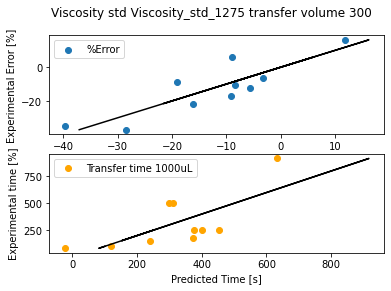

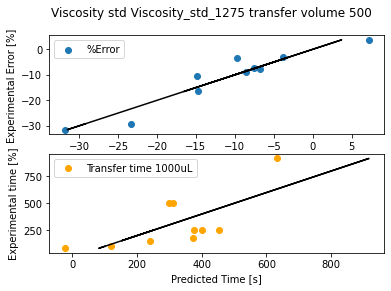

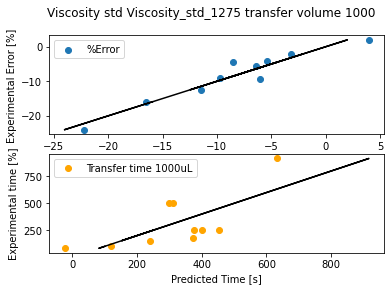

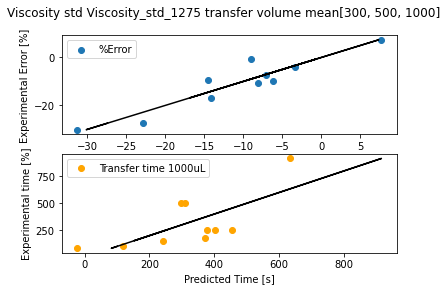

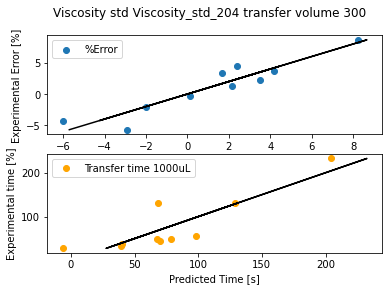

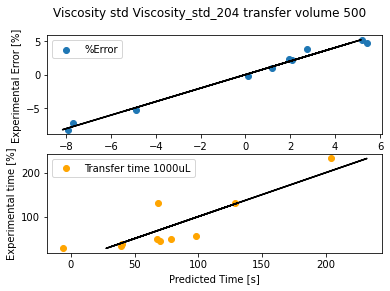

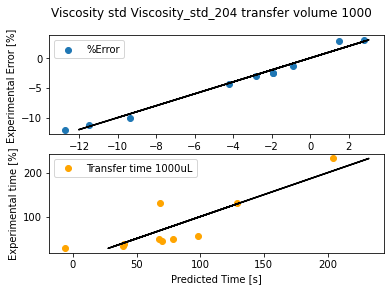

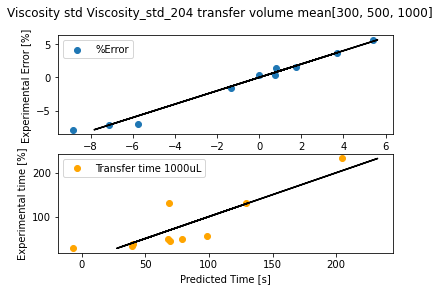

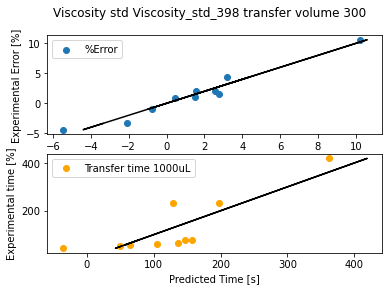

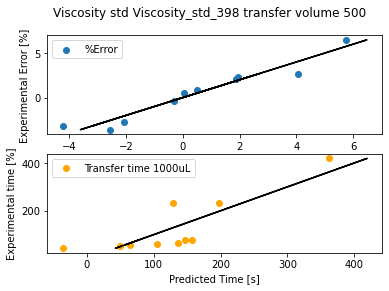

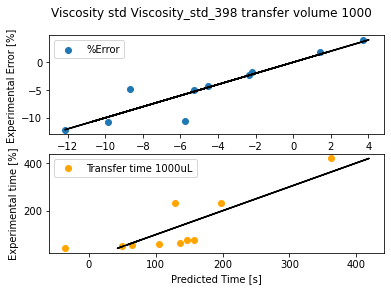

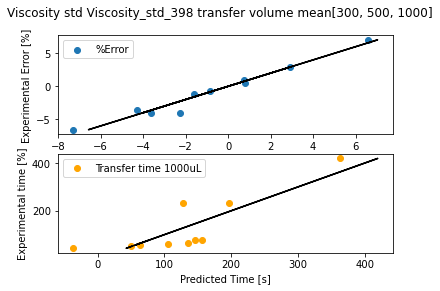

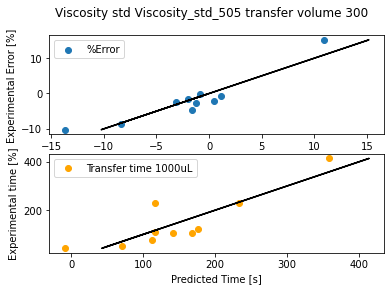

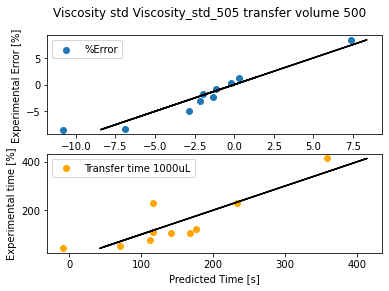

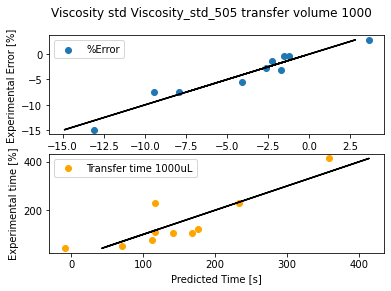

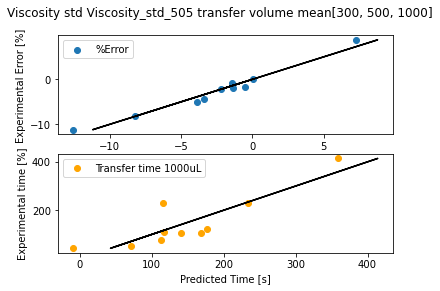

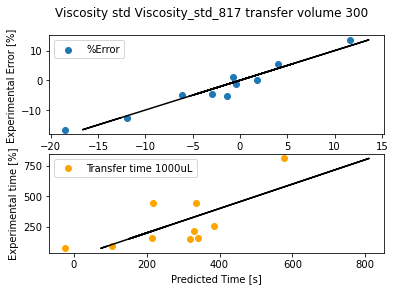

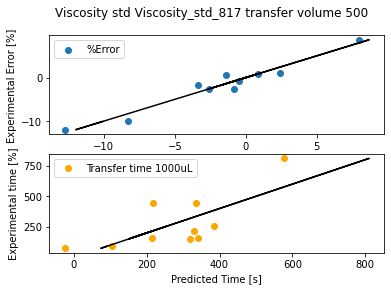

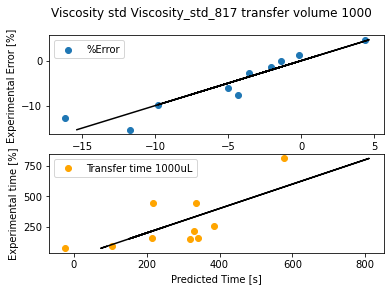

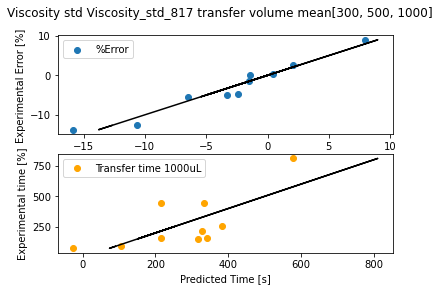

,name,volume,coefs_error,intercept_error,r2_error,coefs_time,intercept_time,r2_time
0,standard_Viscosity_std_1275,300,[ -8.18517714 -11.04185988],-12.686966,0.753153,[-127.11582645 -119.50328537],318.775549,0.501210
1,standard_Viscosity_std_1275,500,[-6.71025035 -7.8909249 ],-11.417125,0.901301,[-127.11582645 -119.50328537],318.775549,0.501210
2,standard_Viscosity_std_1275,1000,[-4.94371372 -4.88096517],-8.541667,0.921155,[-127.11582645 -119.50328537],318.775549,0.501210
3,standard_Viscosity_std_1275,"mean[300, 500, 1000]",[-6.61304707 -7.93791665],-10.881919,0.874232,[-127.11582645 -119.50328537],318.775549,0.501210
4,standard_Viscosity_std_204,300,[-1.44399981 -3.63884551],1.122815,0.875646,[-48.79473599 -26.77834145],78.989472,0.755917
5,standard_Viscosity_std_204,500,[ 0.07819736 -4.66822398],-0.182892,0.989163,[-48.79473599 -26.77834145],78.989472,0.755917
6,standard_Viscosity_std_204,1000,[-0.46467696 -5.08564944],-4.111587,0.985736,[-48.79473599 -26.77834145],78.989472,0.755917
7,standard_Viscosity_std_204,"mean[300, 500, 1000]",[-0.61015981 -4.46423964],-1.057221,0.982405,[-48.79473599 -26.77834145],78.989472,0.755917
8,standard_Viscosity_std_398,300,[-2.40987499 -2.93547482],1.391451,0.955386,[-80.02312252 -55.72656179],130.924649,0.714260
9,standard_Viscosity_std_398,500,[-0.57336057 -2.80105609],0.502768,0.936126,[-80.02312252 -55.72656179],130.924649,0.714260


In [10]:
results_df = pd.DataFrame(columns=['name','volume','coefs_error','intercept_error', 'r2_error' ,'coefs_time','intercept_time', 'r2_time'])
initialization_dfs = {}

for file in os.listdir(parent_path+REPO+r'\\Opentrons_experiments\BOTorch_optimization\VS_code_csv\Best'):
    if 'wrong' not in file:
        initialization_dfs[file.split('_exp3')[0]] = pd.read_csv(parent_path+REPO+'\\Opentrons_experiments\\BOTorch_optimization\\VS_code_csv\\Best\\'+file)
for key in initialization_dfs.keys():
    linear = linear_model.LinearRegression()
    scaler = StandardScaler()
    
    df_duplicates =initialization_dfs[key].where(initialization_dfs[key].duplicated(['aspiration_rate','dispense_rate'],keep=False)==True).dropna(how='all')
    df_incomplete = initialization_dfs[key].where(initialization_dfs[key].duplicated(['aspiration_rate','dispense_rate'],keep=False)==False).dropna(how='all')
    df_mean = pd.DataFrame(columns= initialization_dfs[key].columns)
    for index,values in df_duplicates.drop_duplicates(['aspiration_rate','dispense_rate']).iterrows():
        if len(df_duplicates.loc[index:index+2]) == len([300,500,1000]):
            mean_error =df_duplicates.loc[index:index+2,'%error'].mean()
            df_duplicates.loc[index,'%error'] = mean_error
            df_duplicates.loc[index, 'volume'] ='mean'+str([300,500,1000])
            df_mean = pd.concat([df_mean,initialization_dfs[key].loc[index:index+2],df_duplicates.loc[[index]]])
        else:
            df_incomplete = pd.concat([df_incomplete,df_duplicates.loc[index:index+2]]).drop_duplicates()
    df_mean = pd.concat([df_mean,df_incomplete])
    df_mean = df_mean.reset_index(drop=True)   

    for volume in [ '300.0','500.0','1000.0']:
        index = df_mean.where(df_mean.volume==volume).dropna(how='all').index
        df_mean.loc[index,'volume'] = volume[:-2]

    for volume in [ '300','500','1000','mean[300, 500, 1000]']:
        results_df_row = {'name': f'standard_{key}','volume':volume}
        df_1_vol = df_mean.where(df_mean.volume==volume).dropna(how='all')
        x = df_1_vol.loc[:,['aspiration_rate','dispense_rate']]
        x = scaler.fit_transform(x)
        y = df_1_vol.loc[:,['%error','time_asp_1000']]
        linear.fit(x,y.iloc[:,0])
        results_df_row.update([('coefs_error',str(linear.coef_)),('intercept_error',linear.intercept_),( 'r2_error',linear.score(x,y.iloc[:,0]))])
        
        fig, axs = plt.subplots(2,1)
        axs[0].scatter(linear.predict(x),y.iloc[:,0], label= '%Error')
        axs[0].plot(y.iloc[:,0],y.iloc[:,0], color = 'black')
        axs[0].set_xlabel('Predicted Error [%]')
        axs[0].set_ylabel('Experimental Error [%]')
        axs[0].legend()

        linear.fit(x,y.iloc[:,1])
        results_df_row.update([('coefs_time',str(linear.coef_)),('intercept_time',linear.intercept_),( 'r2_time',linear.score(x,y.iloc[:,1]))])
        results_df = pd.concat([results_df,pd.DataFrame(results_df_row,index=[0])], ignore_index=True)
        
        axs[1].scatter(linear.predict(x),y.iloc[:,1], color = 'orange', label= 'Transfer time 1000uL')
        axs[1].plot(y.iloc[:,1],y.iloc[:,1], color = 'black')
        axs[1].set_xlabel('Predicted Time [s]')
        axs[1].set_ylabel('Experimental time [%]')
        axs[1].legend()

        fig.suptitle(f'Viscosity std {key} transfer volume {volume}')

        plt.show() 
        
results_df.to_csv('optimization_Opentrons_linear_fit_summary.csv', index=False)
results_df

In [ ]:
results_df = pd.DataFrame(columns=['name','volume','degree','coefs_error','intercept_error', 'r2_error' ,'coefs_time','intercept_time', 'r2_time'])

df = pd.read_csv(parent_path+REPO+'\\Opentrons_experiments\\BOTorch_optimization\\VS_code_csv\\Best\\Viscosity_std_1275_exp3_withacq.csv')

df_duplicates =df.where(df.duplicated(['aspiration_rate','dispense_rate'],keep=False)==True).dropna(how='all')
df_incomplete = df.where(df.duplicated(['aspiration_rate','dispense_rate'],keep=False)==False).dropna(how='all')
df_mean = pd.DataFrame(columns= =df.columns)
for index,values in df_duplicates.drop_duplicates(['aspiration_rate','dispense_rate']).iterrows():
    if len(df_duplicates.loc[index:index+2]) == len([300,500,1000]):
        mean_error =df_duplicates.loc[index:index+2,'%error'].mean()
        df_duplicates.loc[index,'%error'] = mean_error
        df_duplicates.loc[index, 'volume'] ='mean'+str([300,500,1000])
        df_mean = pd.concat([df_mean,df_duplicates.loc[index:index+2],df_duplicates.loc[[index]]])
    else:
        df_incomplete = pd.concat([df_incomplete,df_duplicates.loc[index:index+2]]).drop_duplicates()
df_mean = pd.concat([df_mean,df_incomplete])
df_mean = df_mean.reset_index(drop=True)  

for volume in [ '300.0','500.0','1000.0']:
    index = df_mean.where(df_mean.volume==volume).dropna(how='all').index
    df_mean.loc[index,'volume'] = volume[:-2]


for degree in [2,3,4]:
    polyreg= make_pipeline(PolynomialFeatures(degree),LinearRegression())

    for volume in [ '300','500','1000','mean[300, 500, 1000]']:
        results_df_row = {'name': f'standard_1275','volume':volume,'degree':degree}
        df_1_vol = df_mean.where(df_mean.volume==volume).dropna(how='all')
        x = df_1_vol.loc[:,['aspiration_rate','dispense_rate']]
        x = scaler.fit_transform(x)
        y = df_1_vol.loc[:,['time_asp_1000']]
        polyreg.fit(x,y)
        results_df_row.update([('coefs_time',str(polyreg.coef_)),('intercept_time',polyreg.intercept_),( 'r2_time',polyreg.score(x,y.iloc[:,1]))])

        # fig, axs = plt.subplots(2,1)
        # axs[0].scatter(linear.predict(x),y.iloc[:,0], label= '%Error')
        # axs[0].plot(y.iloc[:,0],y.iloc[:,0], color = 'black')
        # axs[0].set_xlabel('Predicted Error [%]')
        # axs[0].set_ylabel('Experimental Error [%]')
        # axs[0].legend()

        linear.fit(x,y.iloc[:,1])
        results_df_row.update([('coefs_time',str(linear.coef_)),('intercept_time',linear.intercept_),( 'r2_time',linear.score(x,y.iloc[:,1]))])
        results_df = pd.concat([results_df,pd.DataFrame(results_df_row,index=[0])], ignore_index=True)
        
        axs[1].scatter(linear.predict(x),y.iloc[:,1], color = 'orange', label= 'Transfer time 1000uL')
        axs[1].plot(y.iloc[:,1],y.iloc[:,1], color = 'black')
        axs[1].set_xlabel('Predicted Time [s]')
        axs[1].set_ylabel('Experimental time [%]')
        axs[1].legend()

        fig.suptitle(f'Viscosity std {key} transfer volume {volume}')

        plt.show() 
        
    results_df.to_csv('optimization_Opentrons_linear_fit_summary.csv', index=False)
    results_df

In [26]:
X = pd.DataFrame({'x': [300, 170, 288, 360, 319, 330, 520, 345, 399]})
y = pd.DataFrame({'y': [305000, 270000, 360000, 370000, 379000, 405000, 407500, 450000, 450000]})

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
degree=2
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(X,y)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

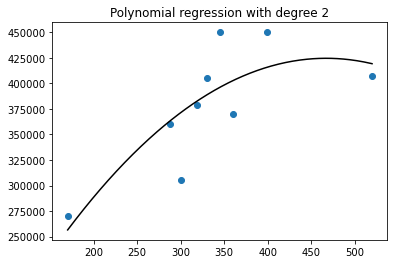

In [28]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(X,y)
plt.plot(X_seq,polyreg.predict(X_seq),color="black")
plt.title("Polynomial regression with degree "+str(degree))
plt.show()


In [31]:
poly = PolynomialFeatures(degree, interaction_only=False)
x_t = poly.fit_transform(X)
x_t

array([[1.00000e+00, 3.00000e+02, 9.00000e+04],
       [1.00000e+00, 1.70000e+02, 2.89000e+04],
       [1.00000e+00, 2.88000e+02, 8.29440e+04],
       [1.00000e+00, 3.60000e+02, 1.29600e+05],
       [1.00000e+00, 3.19000e+02, 1.01761e+05],
       [1.00000e+00, 3.30000e+02, 1.08900e+05],
       [1.00000e+00, 5.20000e+02, 2.70400e+05],
       [1.00000e+00, 3.45000e+02, 1.19025e+05],
       [1.00000e+00, 3.99000e+02, 1.59201e+05]])

In [16]:
polyreg.s

,x
0,300
1,170
2,288
3,360
4,319
5,330
6,520
7,345
8,399
9,479
